<a href="https://colab.research.google.com/github/HedersonSantos/jpx_tokyo/blob/main/jpx_tokyo_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
from google.colab import files, drive
from pathlib import Path
from sklearn.model_selection import train_test_split
import io, re, os
import matplotlib.pyplot as plt
import seaborn as sns
#import jpx_tokyo_market_prediction

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

In [7]:
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/
path = '/gdrive/My Drive/Colab Notebooks'


Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


In [8]:
dados = pd.read_csv('stock_prices.csv',index_col='Date', parse_dates=True).sort_values(by='Date')
dados.fillna(0,inplace=True)
dados.head(3)

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,0.0,False,0.000730
2017-01-04,20170104_7412,7412,719.0,725.0,719.0,721.0,201400,1.0,0.0,False,0.000000
2017-01-04,20170104_7408,7408,2459.0,2518.0,2447.0,2500.0,110900,1.0,0.0,False,0.004421


In [9]:
colunas=['Open','High','Low','Close','Volume']
alvo=['Target']
#dados = dados[~dados['Target'].isna()]
#dados = dados[~dados['Open'].isna()]
dados = dados[dados.index>='2020-01-01 00:00:00']


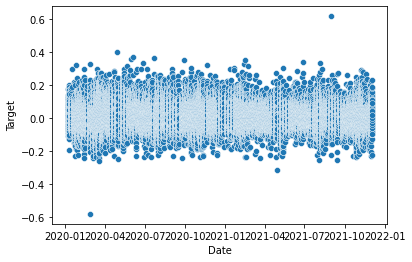

In [19]:
sns.scatterplot( x=dados.index, y=dados.Target)


In [22]:
df = dados.copy()
df = df[df.index>='2021-11-01 00:00:00']
fig = px.scatter( x=df.index, y=df.Target, title='Time Series for Target')
fig.show()

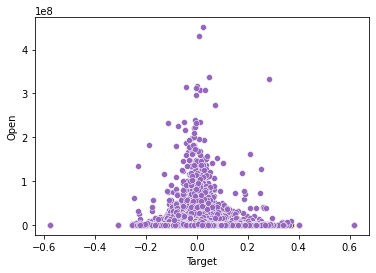

In [25]:
for c in colunas:
  sns.scatterplot(x=dados['Target'], y=dados[c])